In [1]:
import json

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew, norm, exponnorm, expon

%matplotlib notebook

In [2]:
years = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/years.csv")
events = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/events.csv")
team_years = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/team_years.csv")

In [3]:
events.head()
events[events.year == 2017].groupby("week").agg({"elo_acc": "mean"})[1:7]

,elo_acc
week,
2,0.656563
3,0.657960
4,0.671800
5,0.654809
6,0.644116
7,0.632943


In [4]:
years = []
for year in range(2002, 2021):
    years.append(team_years[team_years.year == year]["elo_mean"])
years.append(team_years.elo_mean)

In [5]:
print("Year\tMean\tSD  \t\tSkew\t\tKurtosis")
for i, year_data in enumerate(years[:-1]):
    print(2002 + i, "\t", round(year_data.mean()), "\t", round(year_data.std(), 2), "  \t", round(skew(year_data), 2), "\t\t", round(kurtosis(year_data), 2))
print("All", "\t", round(years[-1].mean()), "\t", round(years[-1].std(), 2), "  \t", round(skew(years[-1]), 2), "\t\t", round(kurtosis(years[-1]), 2))

Year	Mean	SD  		Skew		Kurtosis
2002 	 1500 	 35.88   	 0.33 		 0.21
2003 	 1478 	 62.51   	 0.46 		 0.08
2004 	 1483 	 68.66   	 1.05 		 1.44
2005 	 1489 	 88.29   	 0.91 		 1.09
2006 	 1482 	 77.08   	 1.62 		 4.17
2007 	 1484 	 77.75   	 1.73 		 5.48
2008 	 1485 	 72.14   	 1.82 		 5.52
2009 	 1484 	 76.62   	 1.42 		 3.01
2010 	 1485 	 77.43   	 2.06 		 7.72
2011 	 1486 	 79.09   	 2.01 		 5.68
2012 	 1486 	 73.59   	 1.94 		 5.54
2013 	 1488 	 80.56   	 1.87 		 5.45
2014 	 1490 	 86.23   	 1.51 		 3.24
2015 	 1497 	 82.48   	 2.0 		 6.34
2016 	 1500 	 76.46   	 1.45 		 3.38
2017 	 1501 	 73.44   	 0.79 		 0.73
2018 	 1505 	 99.94   	 1.12 		 1.36
2019 	 1512 	 85.08   	 0.91 		 0.94
2020 	 1533 	 85.93   	 0.75 		 0.44
All 	 1496 	 81.72   	 1.41 		 3.16


<IPython.core.display.Javascript object>


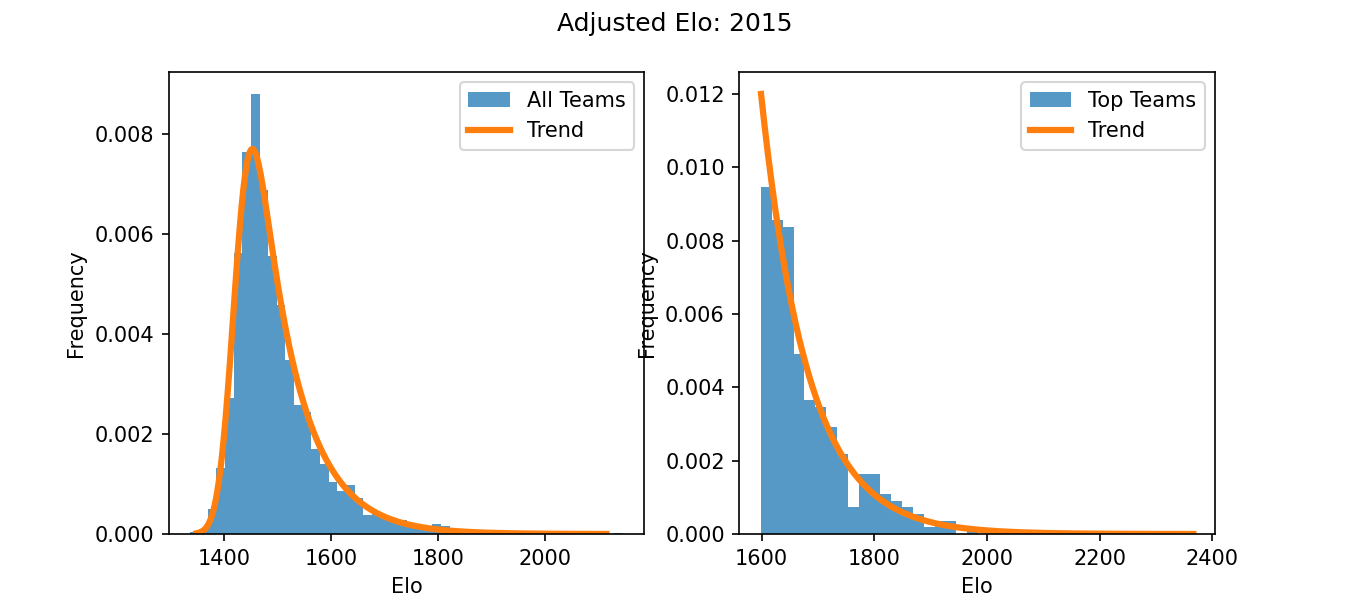

In [6]:
def get_subset(data):
    return data[(data > data.quantile(0.90)) & (data < data.quantile(0.999))]


for year in range(2015, 2016):
    all_data = years[year - 2002]
    data = get_subset(all_data)

    config = exponnorm.fit(all_data)
    fig, axs = plt.subplots(1, 2, figsize=(9, 4))
    axs[0].hist(all_data, density=True, bins=50, alpha=0.75, label="All Teams")
    x = np.linspace(exponnorm.ppf(0.0001, *config), exponnorm.ppf(0.9999, *config), 1000)
    axs[0].plot(x, exponnorm.pdf(x, *config), lw=3, label="Trend")
    fig.show()

    config2 = expon.fit(data)
    axs[1].hist(data, density=True, bins=20, alpha=0.75, label="Top Teams")
    x = np.linspace(expon.ppf(0.0001, *config2), expon.ppf(0.9999, *config2), 1000)
    axs[1].plot(x, expon.pdf(x, *config2), lw=3, label="Trend")
    
    axs[0].set_xlabel("Elo")
    axs[0].set_ylabel("Frequency")
    axs[1].set_xlabel("Elo")
    axs[1].set_ylabel("Frequency")
    
    fig.suptitle("Adjusted Elo: " + str(year))
    
    axs[0].legend()
    axs[1].legend()
    fig.show()

In [7]:
all_configs = [exponnorm.fit(year_data) for year_data in years]
configs = [expon.fit(get_subset(year_data)) for year_data in years]

In [8]:
team_years["elo_adj"] = 0

for year in range(2002, 2021):
    cutoff = team_years[team_years.year == year].elo_mean.quantile(0.90)
    subset = (team_years.year == year) & (team_years.elo_mean > cutoff)
    team_years.loc[team_years.year == year, "elo_adj"] = norm.ppf(exponnorm.cdf(team_years[team_years.year == year].elo_mean, *all_configs[year - 2002]), 1500, 100)
    team_years.loc[subset, "elo_adj"] = norm.ppf(0.9 + 0.1 * expon.cdf(team_years[subset].elo_mean, *configs[year - 2002]), 1500, 100)

In [9]:
cols = ["year", "team", "elo_mean", "winrate", "opr_rank", "elo_rank", "elo_adj"]
team_years.sort_values(by=["elo_adj"], ascending=False)[cols].head(100)

,year,team,elo_mean,winrate,opr_rank,elo_rank,elo_adj
12596,2010,1114,2076.69,0.9437,2,2,1865.442441
22045,2015,1114,2144.74,0.9079,3,1,1862.781688
9472,2007,1114,2004.73,0.8158,304,1,1862.757293
4575,2010,469,2060.02,0.7597,1,1,1859.670730
6820,2017,254,1891.13,0.8644,3,1,1858.810684
...,...,...,...,...,...,...,...
5902,2014,359,1879.53,0.8060,11,8,1786.069725
5802,2014,148,1878.67,0.8182,17,10,1785.680938
6487,2016,225,1840.51,0.8239,49,12,1785.592662
7045,2017,971,1774.68,0.7872,15,9,1785.176734


In [10]:
top_100 = team_years.sort_values(by=["elo_mean"], ascending=False)[cols].head(100)
adj_top_100 = team_years.sort_values(by=["elo_adj"], ascending=False)[cols].head(100)

display(adj_top_100.groupby("year").agg({"team": "count"}).sort_values(by=["team"], ascending=False).head(25))
display(top_100.groupby("year").agg({"team": "count"}).sort_values(by=["team"], ascending=False).head(25))

,team
year,
2016,11
2017,11
2014,9
2012,8
2013,8
2019,7
2010,7
2015,7
2011,5


,team
year,
2018,16
2015,12
2014,11
2013,10
2011,8
2016,8
2010,7
2012,7
2019,6


In [11]:

teams = [254, 1114, 2056]
for team in teams:
    print(team_years[(team_years.year >= 2006) & (team_years.year <= 2015) & (team_years.team == team)].elo_adj.mean())

1782.880028268043
1840.1252476971883
1797.8196760817582
